Kaggle days offline competition was hold during 10:30 - 18:30 12th Dec 2019
Following is my solution code for 77 th place / 88 teams

https://www.kaggle.com/c/kaggle-days-tokyo/overview

# Import Libraries

In [936]:
import gc
import os,csv
import logging
import pickle
from datetime import datetime
import warnings
import numpy as np
import random
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
import rgf
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import StratifiedKFold, KFold,RepeatedKFold
warnings.filterwarnings('ignore')
import time
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

In [363]:
def reduce_mem_usage(df, use_float16=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            # skip datetime type or categorical type
            continue
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [369]:
def change_times(df):
    df["datetime"] = pd.to_datetime(df["ts"])
    df["weekday"]     = df["datetime"].dt.dayofweek
    df['hour']        = df["datetime"].dt.hour
    df.loc[df.hour<12, "hourinday"] = 0 #Morning
    df.loc[(df.hour>12)&(df.hour<=18), "hourinday"] = 1 #Afternoon
    df.loc[(df.hour>18)&(df.hour<=23), "hourinday"]  = 2 #Night
    return df

# Import Data

In [701]:
PATH = '../input'
SUBPATH = '../submission'
target = 'age'
os.listdir(PATH)


['kaggle-days-tokyo.zip',
 'test.csv',
 'sample_submission.csv',
 'train.csv',
 '.ipynb_checkpoints',
 'kiji_metadata.csv']

In [925]:
%%time
train_df = pd.read_csv(f'{PATH}/train.csv')
test_df = pd.read_csv(f'{PATH}/test.csv')
kiji_df = pd.read_csv(f'{PATH}/kiji_metadata.csv')
sub_df = pd.read_csv(f'{PATH}/sample_submission.csv')

CPU times: user 4.72 s, sys: 272 ms, total: 4.99 s
Wall time: 3.83 s


In [703]:
kiji_df.service_category.unique()

array(['paper', 'news', nan], dtype=object)

In [704]:
len(kiji_df.kiji_id_raw.unique())

26549

In [758]:
kiji_df['service_category'] = kiji_df['service_category'].fillna('null')
kiji_df['moji_count'] = kiji_df['moji_count'].fillna(kiji_df['moji_count'].mean())

In [759]:
train_df.columns

Index(['age', 'kiji_id', 'user_id', 'ts', 'ig_ctx_red_viewed_percent',
       'ig_ctx_red_elapsed_since_page_load', 'er_geo_bc_flag',
       'ig_ctx_product', 'er_geo_pref_j_name', 'er_geo_city_j_name',
       'er_geo_country_code', 'er_dev_browser_family',
       'er_dev_browser_version', 'er_dev_device_name', 'er_dev_device_type',
       'er_dev_manufacture', 'er_dev_os_family', 'er_dev_os_version',
       'er_rfs_reffered_visit', 'er_rfs_service_name', 'er_rfs_service_type',
       'er_rfc_kiji_id_raw', 'ig_usr_connection'],
      dtype='object')

In [707]:
kiji_df.isnull().sum()

kiji_id_raw              0
display_time            18
service_category         0
title                   18
title2               21452
title3               22607
genres                  18
belong_topic_info       18
keywords                18
body                    18
moji_count               0
dtype: int64

In [760]:
%%time
train_df = pd.merge(train_df, kiji_df[['kiji_id_raw','service_category', 'moji_count','title']], left_on = 'kiji_id', right_on = 'kiji_id_raw', how = 'left')
test_df = pd.merge(test_df, kiji_df[['kiji_id_raw','service_category', 'moji_count','title']],left_on = 'kiji_id', right_on = 'kiji_id_raw', how = 'left')

CPU times: user 1.46 s, sys: 176 ms, total: 1.64 s
Wall time: 957 ms


In [709]:
train_df.isnull().sum()

age                                        0
kiji_id                                    0
user_id                                    0
ts                                         0
ig_ctx_red_viewed_percent              94058
ig_ctx_red_elapsed_since_page_load     89809
er_geo_bc_flag                             0
ig_ctx_product                             0
er_geo_pref_j_name                    214018
er_geo_city_j_name                    214018
er_geo_country_code                   193133
er_dev_browser_family                 366079
er_dev_browser_version                366666
er_dev_device_name                     79625
er_dev_device_type                         0
er_dev_manufacture                    192937
er_dev_os_family                           0
er_dev_os_version                       6471
er_rfs_reffered_visit                  91405
er_rfs_service_name                   473711
er_rfs_service_type                   473711
er_rfc_kiji_id_raw                    403745
ig_usr_con

In [926]:
kiji_df.head(0)

,kiji_id_raw,display_time,service_category,title,title2,title3,genres,belong_topic_info,keywords,body,moji_count


In [652]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
tfidf = TfidfVectorizer(ngram_range=(1,3))
tsvd = TruncatedSVD(n_components = 128, n_iter=5)
tf_title_train = tfidf.fit_transform(train_df["title"].fillna("None").values)
tf_title_train = tsvd.fit_transform(tf_title_train)
tf_title_test = tfidf.fit_transform(test_df["title"].fillna("None").values)
tf_title_test = tsvd.fit_transform(tf_title_test)

CPU times: user 1min 28s, sys: 14.1 s, total: 1min 42s
Wall time: 54.4 s


In [654]:
tf_train = pd.DataFrame(tf_title_train)
tf_test = pd.DataFrame(tf_title_test)

In [675]:
tftrnnm = [ 'tfidf_'+str(i) for i in tf_train.columns]

In [676]:
tf_train.columns = tftrnnm
tf_test.columns = tftrnnm

In [710]:
train_df = pd.concat([train_df,tf_train], axis = 1 )
test_df = pd.concat([test_df,tf_test], axis = 1 )

In [711]:
train_df.shape

(477057, 155)

In [712]:
test_df.shape

(324445, 154)

# Data Check

In [7]:
print(train_df.shape)
print(test_df.shape)
print(kiji_df.shape)

(477057, 23)
(324445, 22)
(26549, 11)


In [927]:
train_df.head(0)

,age,kiji_id,user_id,ts,ig_ctx_red_viewed_percent,ig_ctx_red_elapsed_since_page_load,er_geo_bc_flag,ig_ctx_product,er_geo_pref_j_name,er_geo_city_j_name,er_geo_country_code,er_dev_browser_family,er_dev_browser_version,er_dev_device_name,er_dev_device_type,er_dev_manufacture,er_dev_os_family,er_dev_os_version,er_rfs_reffered_visit,er_rfs_service_name,er_rfs_service_type,er_rfc_kiji_id_raw,ig_usr_connection


In [714]:
train_df.dtypes

age                                   float64
kiji_id                                object
user_id                                 int64
ts                                     object
ig_ctx_red_viewed_percent             float64
ig_ctx_red_elapsed_since_page_load    float64
er_geo_bc_flag                          int64
ig_ctx_product                         object
er_geo_pref_j_name                     object
er_geo_city_j_name                     object
er_geo_country_code                    object
er_dev_browser_family                  object
er_dev_browser_version                 object
er_dev_device_name                     object
er_dev_device_type                     object
er_dev_manufacture                     object
er_dev_os_family                       object
er_dev_os_version                      object
er_rfs_reffered_visit                  object
er_rfs_service_name                    object
er_rfs_service_type                    object
er_rfc_kiji_id_raw                

In [761]:
t_t = train_df.dtypes
cat_list = t_t[t_t == 'object'].index.tolist()
num_list = t_t[t_t != 'object'].index.tolist()
cat_list.remove('kiji_id')
cat_list.remove('ts')
cat_list.remove('title')
cat_list.append('er_geo_bc_flag')
num_list.remove('age')
num_list.remove('user_id')
num_list.remove('er_geo_bc_flag')
num_list.append('ts')

In [762]:
num_list.append('user_id')
cat_list.append('user_id')
num_list.append('kiji_id')
cat_list.append('kiji_id')

In [776]:
num_list

['ig_ctx_red_viewed_percent',
 'ig_ctx_red_elapsed_since_page_load',
 'moji_count',
 'ts',
 'user_id',
 'kiji_id']

In [764]:
cat_list

['ig_ctx_product',
 'er_geo_pref_j_name',
 'er_geo_city_j_name',
 'er_geo_country_code',
 'er_dev_browser_family',
 'er_dev_browser_version',
 'er_dev_device_name',
 'er_dev_device_type',
 'er_dev_manufacture',
 'er_dev_os_family',
 'er_dev_os_version',
 'er_rfs_reffered_visit',
 'er_rfs_service_name',
 'er_rfs_service_type',
 'er_rfc_kiji_id_raw',
 'ig_usr_connection',
 'kiji_id_raw',
 'service_category',
 'er_geo_bc_flag',
 'user_id',
 'kiji_id']

In [29]:
#基礎統計量　train
train_df.describe()

,age,user_id,ig_ctx_red_viewed_percent,ig_ctx_red_elapsed_since_page_load,er_geo_bc_flag
count,477057.000000,4.770570e+05,382999.000000,387248.000000,477057.000000
mean,45.480662,5.069609e+09,88.292993,124.364831,0.093062
std,13.650835,2.900851e+09,23.740932,2361.694252,0.290520
min,19.000000,1.010270e+06,0.000000,0.000000,0.000000
25%,34.000000,2.564377e+09,96.836550,7.877922,0.000000
50%,45.000000,5.113663e+09,100.000000,30.834607,0.000000
75%,55.000000,7.599922e+09,100.000000,80.038000,0.000000
max,90.000000,9.999625e+09,139.013000,427918.904000,1.000000


In [30]:
#基礎統計量　test
test_df.describe()

,user_id,ig_ctx_red_viewed_percent,ig_ctx_red_elapsed_since_page_load,er_geo_bc_flag
count,3.244450e+05,264996.000000,267693.000000,324445.000000
mean,5.053282e+09,88.412571,134.777444,0.095314
std,2.870190e+09,23.694047,2309.446223,0.293648
min,1.406160e+06,0.000000,0.000000,0.000000
25%,2.573918e+09,97.855875,8.303943,0.000000
50%,5.063415e+09,100.000000,31.998717,0.000000
75%,7.565872e+09,100.000000,82.032000,0.000000
max,9.999655e+09,144.294000,352172.570000,1.000000


In [37]:
# user_idのかぶりチェック
len(set(train_df.user_id.unique()) & set(test_df.user_id.unique()))
## かぶりなし

0

In [41]:
len(set(train_df.user_id.unique()))

14088

# Prepare Data

In [928]:
train_df.tail(0)

,age,kiji_id,user_id,ts,ig_ctx_red_viewed_percent,ig_ctx_red_elapsed_since_page_load,er_geo_bc_flag,ig_ctx_product,er_geo_pref_j_name,er_geo_city_j_name,er_geo_country_code,er_dev_browser_family,er_dev_browser_version,er_dev_device_name,er_dev_device_type,er_dev_manufacture,er_dev_os_family,er_dev_os_version,er_rfs_reffered_visit,er_rfs_service_name,er_rfs_service_type,er_rfc_kiji_id_raw,ig_usr_connection


In [929]:
test_df.tail(0)

,kiji_id,user_id,ts,ig_ctx_red_viewed_percent,ig_ctx_red_elapsed_since_page_load,er_geo_bc_flag,ig_ctx_product,er_geo_pref_j_name,er_geo_city_j_name,er_geo_country_code,er_dev_browser_family,er_dev_browser_version,er_dev_device_name,er_dev_device_type,er_dev_manufacture,er_dev_os_family,er_dev_os_version,er_rfs_reffered_visit,er_rfs_service_name,er_rfs_service_type,er_rfc_kiji_id_raw,ig_usr_connection


In [765]:
%%time
df_num_all = pd.concat([train_df[num_list], test_df[num_list] ], axis = 0)
df_num_all.reset_index(inplace=True, drop=True)
df_cat_all = pd.concat([train_df[cat_list], test_df[cat_list] ], axis = 0)
df_cat_all.reset_index(inplace=True, drop=True)
df_all = pd.concat([train_df, test_df], axis = 0)
df_all.reset_index(inplace=True, drop=True)

CPU times: user 7.06 s, sys: 816 ms, total: 7.87 s
Wall time: 2.7 s


In [51]:
len(train_df) + len(test_df)

801502

In [61]:
df_num_all.shape

(801502, 4)

In [62]:
df_cat_all.shape

(801502, 19)

In [766]:
df_num_all.columns

Index(['ig_ctx_red_viewed_percent', 'ig_ctx_red_elapsed_since_page_load',
       'moji_count', 'ts', 'user_id', 'kiji_id'],
      dtype='object')

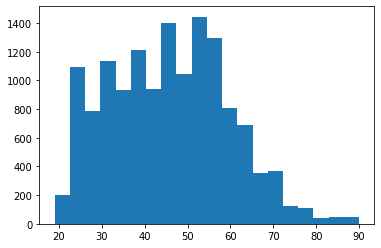

In [73]:
plt.hist(target, bins = 20)
plt.show()

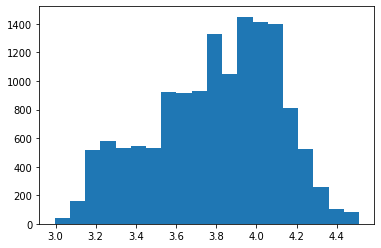

In [74]:
plt.hist(np.log1p(target), bins = 20)
plt.show()

## 数値変数

### 欠損

In [767]:
df_num_all.isnull().sum()

ig_ctx_red_viewed_percent             153507
ig_ctx_red_elapsed_since_page_load    146561
moji_count                                 0
ts                                         0
user_id                                    0
kiji_id                                    0
dtype: int64

In [768]:
%%time
df_num_all['ig_ctx_red_viewed_percent'] \
= df_num_all['ig_ctx_red_viewed_percent'].fillna(df_num_all['ig_ctx_red_viewed_percent'].median()) #最頻値で欠損値を埋める
df_num_all['ig_ctx_red_elapsed_since_page_load'] \
= df_num_all['ig_ctx_red_elapsed_since_page_load'].fillna(df_num_all['ig_ctx_red_elapsed_since_page_load'].median())
df_num_all.isnull().sum()

CPU times: user 512 ms, sys: 32 ms, total: 544 ms
Wall time: 148 ms


ig_ctx_red_viewed_percent             0
ig_ctx_red_elapsed_since_page_load    0
moji_count                            0
ts                                    0
user_id                               0
kiji_id                               0
dtype: int64

In [769]:
df_num_all.dtypes

ig_ctx_red_viewed_percent             float64
ig_ctx_red_elapsed_since_page_load    float64
moji_count                            float64
ts                                     object
user_id                                 int64
kiji_id                                object
dtype: object

### 時間の変換

In [770]:
df_num_all.shape

(801502, 6)

In [771]:
%%time
df_num_all= change_times(df_num_all)

CPU times: user 1.28 s, sys: 36 ms, total: 1.31 s
Wall time: 540 ms


In [725]:
df_num_all.shape

(801502, 138)

In [773]:
df_num_all['isholiday'] = 0
df_num_all.loc[df_num_all.weekday.isin([5, 6]),'isholiday']=1 

In [774]:
df_num_all.isholiday.unique()

array([0, 1])

In [777]:
num_varlist = ['ig_ctx_red_viewed_percent',
 'ig_ctx_red_elapsed_since_page_load',
 'moji_count',]

In [858]:
%%time
df_num = pd.DataFrame()
df_num_all['ig_ctx_red_viewed_percent'] = df_num_all['ig_ctx_red_viewed_percent'].astype('float')
df_num_all['ig_ctx_red_elapsed_since_page_load'] = df_num_all['ig_ctx_red_elapsed_since_page_load'].astype('float')
df_num_all['holiday_readrate'] = df_num_all.groupby(['user_id'])['isholiday'].sum()\
/df_num_all.groupby(['user_id'])['isholiday'].count()
for var in num_varlist:
    df_num[var+'_max'] = df_num_all.groupby('user_id')[var].max()
    df_num[var+'_median'] = df_num_all.groupby('user_id')[var].median()
    df_num[var+'_std'] = df_num_all.groupby('user_id')[var].std()
    df_num[var+'_max2min'] = df_num_all.groupby('user_id')[var].max()/\
    (1+df_num_all.groupby('user_id')[var].min())
    df_num[var+'_wk_mode'] = df_num_all.groupby(['user_id'])['weekday'].apply(lambda x: x.mode()[0])
    df_num[var+'_hr_mode'] = df_num_all.groupby(['user_id'])['hour'].apply(lambda x: x.mode()[0])
    df_num[var+'_wkd_mean'] = df_num_all[df_num_all.isholiday ==0].groupby(['user_id'])[var].mean()
    df_num[var+'_wkd_mean'] = df_num_all[df_num_all.isholiday ==1].groupby(['user_id'])[var].mean()
    
df_num.reset_index(inplace=True)

CPU times: user 43.1 s, sys: 296 ms, total: 43.4 s
Wall time: 42.5 s


In [859]:
df_num['holiday_readrate'] = df_num_all.groupby(['user_id'])['isholiday'].sum()\
/df_num_all.groupby(['user_id'])['isholiday'].count()

In [860]:
df_num.columns

Index(['user_id', 'ig_ctx_red_viewed_percent_max',
       'ig_ctx_red_viewed_percent_median', 'ig_ctx_red_viewed_percent_std',
       'ig_ctx_red_viewed_percent_max2min',
       'ig_ctx_red_viewed_percent_wk_mode',
       'ig_ctx_red_viewed_percent_hr_mode',
       'ig_ctx_red_viewed_percent_wkd_mean',
       'ig_ctx_red_elapsed_since_page_load_max',
       'ig_ctx_red_elapsed_since_page_load_median',
       'ig_ctx_red_elapsed_since_page_load_std',
       'ig_ctx_red_elapsed_since_page_load_max2min',
       'ig_ctx_red_elapsed_since_page_load_wk_mode',
       'ig_ctx_red_elapsed_since_page_load_hr_mode',
       'ig_ctx_red_elapsed_since_page_load_wkd_mean', 'moji_count_max',
       'moji_count_median', 'moji_count_std', 'moji_count_max2min',
       'moji_count_wk_mode', 'moji_count_hr_mode', 'moji_count_wkd_mean',
       'holiday_readrate'],
      dtype='object')

In [861]:
var_num = ['user_id','ig_ctx_red_viewed_percent_max',
       'ig_ctx_red_viewed_percent_median', 'ig_ctx_red_viewed_percent_std',
       'ig_ctx_red_viewed_percent_max2min',
       'ig_ctx_red_viewed_percent_wk_mode',
       'ig_ctx_red_viewed_percent_hr_mode',
       'ig_ctx_red_viewed_percent_wkd_mean',
       'ig_ctx_red_elapsed_since_page_load_max',
       'ig_ctx_red_elapsed_since_page_load_median',
       'ig_ctx_red_elapsed_since_page_load_std',
       'ig_ctx_red_elapsed_since_page_load_max2min',
       'ig_ctx_red_elapsed_since_page_load_wk_mode',
       'ig_ctx_red_elapsed_since_page_load_hr_mode',
       'ig_ctx_red_elapsed_since_page_load_wkd_mean', 'moji_count_max',
       'moji_count_median', 'moji_count_std', 'moji_count_max2min',
       'moji_count_wk_mode', 'moji_count_hr_mode', 'moji_count_wkd_mean',
       'holiday_readrate']

In [862]:
df_num = df_num[var_num]

## カテゴリカル変数

### 欠損値

In [784]:
list_cat = ['ig_ctx_product', 'er_geo_pref_j_name', 'er_geo_city_j_name',
       'er_geo_country_code', 'er_dev_browser_family',
       'er_dev_browser_version', 'er_dev_device_name', 'er_dev_device_type',
       'er_dev_manufacture', 'er_dev_os_family', 'er_dev_os_version',
       'er_rfs_reffered_visit', 'er_rfs_service_name', 'er_rfs_service_type',
       'er_rfc_kiji_id_raw', 'ig_usr_connection', 'er_geo_bc_flag']

In [785]:
train_df[cat_list].columns

Index(['ig_ctx_product', 'er_geo_pref_j_name', 'er_geo_city_j_name',
       'er_geo_country_code', 'er_dev_browser_family',
       'er_dev_browser_version', 'er_dev_device_name', 'er_dev_device_type',
       'er_dev_manufacture', 'er_dev_os_family', 'er_dev_os_version',
       'er_rfs_reffered_visit', 'er_rfs_service_name', 'er_rfs_service_type',
       'er_rfc_kiji_id_raw', 'ig_usr_connection', 'kiji_id_raw',
       'service_category', 'er_geo_bc_flag', 'user_id', 'kiji_id'],
      dtype='object')

In [210]:
for var in cat_list:
    print(var +' ' + str(len(df_cat_all[var].unique()) ) )

ig_ctx_product 5
er_geo_pref_j_name 48
er_geo_city_j_name 817
er_geo_country_code 84
er_dev_browser_family 11
er_dev_browser_version 201
er_dev_device_name 673
er_dev_device_type 2
er_dev_manufacture 5
er_dev_os_family 7
er_dev_os_version 103
er_rfs_reffered_visit 2
er_rfs_service_name 23
er_rfs_service_type 9
er_rfc_kiji_id_raw 12682
ig_usr_connection 8
er_geo_bc_flag 2
user_id 23487
kiji_id 26349


In [884]:
df_cat_all['er_dev_os_version'] = df_cat_all['er_dev_os_version'].str.split('.', expand=True).iloc[:,0].values

In [568]:
common_device = list(set(test_df['er_dev_device_name'].unique()) & set(train_df['er_dev_device_name'].unique()))

In [567]:
len(set(test_df['er_dev_device_name'].unique()) & set(train_df['er_dev_device_name'].unique()) )

389

In [885]:
cat_list = ['ig_ctx_product',
            'er_geo_pref_j_name',
            'er_geo_country_code',
            'er_dev_browser_family',
            'er_dev_device_type',
            'er_dev_manufacture',
            'er_dev_os_family',
            'er_dev_os_version',
            'er_rfs_reffered_visit',
            'er_rfs_service_name',
            'er_rfs_service_type',
            'er_geo_bc_flag',
            'user_id',
            'kiji_id',
           ]

In [886]:
df_cat_all[cat_list] = df_cat_all[cat_list].fillna('null')
df_cat_all[cat_list].isnull().sum()

ig_ctx_product           0
er_geo_pref_j_name       0
er_geo_country_code      0
er_dev_browser_family    0
er_dev_device_type       0
er_dev_manufacture       0
er_dev_os_family         0
er_dev_os_version        0
er_rfs_reffered_visit    0
er_rfs_service_name      0
er_rfs_service_type      0
er_geo_bc_flag           0
user_id                  0
kiji_id                  0
dtype: int64

In [887]:
var_list = ['ig_ctx_product',
            'er_geo_pref_j_name',
            'er_geo_country_code',
            'er_dev_browser_family',
            'er_dev_device_type',
            'er_dev_manufacture',
            'er_dev_os_family',
            'er_dev_os_version',
            'er_rfs_reffered_visit',
            'er_rfs_service_name',
            'er_rfs_service_type',
            'er_geo_bc_flag']

In [304]:
pd.DataFrame(df_all.groupby(var)['ig_ctx_red_elapsed_since_page_load'].median()).reset_index()

,er_geo_bc_flag,ig_ctx_red_elapsed_since_page_load
0,0,32.453453
1,1,19.077500


In [313]:
mapper = pd.DataFrame(df_all.groupby('ig_ctx_product')['ig_ctx_red_elapsed_since_page_load'].median())

In [317]:
#mapper = mapper[['ig_ctx_red_elapsed_since_page_load', var]]
#mapper  = mapper.to_dict()
mapper['ig_ctx_red_elapsed_since_page_load']

{'DS-App': 35.416,
 'DS-Responsive': 26.747999999999998,
 'DS-Viewer': 9.273,
 'DS-Web-PC': 13.656,
 'DS-Web-Viewer': 1.507}

In [888]:
%%time
df_cat = pd.DataFrame()

for var in var_list:
    mapper1 = pd.DataFrame(df_all.groupby(var)['ig_ctx_red_elapsed_since_page_load'].median()).to_dict()
    mapper1 = mapper1['ig_ctx_red_elapsed_since_page_load']
    mapper1['null'] = -99
    mapper2 = pd.DataFrame(df_all.groupby(var)['ig_ctx_red_viewed_percent'].median()).to_dict()
    mapper2 = mapper2['ig_ctx_red_viewed_percent']
    mapper2['null'] = -99
    df_cat[var+'_mode'] = df_cat_all.groupby('user_id')[var].apply(lambda x: x.mode()[0])
    df_cat[var+'_ucnt'] = df_cat_all.groupby('user_id')[var].apply(lambda x: x.nunique())
    df_cat[var+'_ig_ctx_red_elapsed_since_page_load_med'] = df_cat[var+'_mode'].map(mapper1)
    df_cat[var+'_ig_ctx_red_viewed_percent_med'] = df_cat[var+'_mode'].map(mapper2)
    

CPU times: user 2min 53s, sys: 3.5 s, total: 2min 57s
Wall time: 2min 53s


In [889]:
%%time
for var in var_list:
    df_cat.drop(var+'_mode', axis=1, inplace=True)

CPU times: user 100 ms, sys: 8 ms, total: 108 ms
Wall time: 105 ms


In [930]:
df_cat.reset_index(inplace=True)
df_cat.head(0)

,level_0,index,user_id,ig_ctx_product_ucnt,ig_ctx_product_ig_ctx_red_elapsed_since_page_load_med,ig_ctx_product_ig_ctx_red_viewed_percent_med,er_geo_pref_j_name_ucnt,er_geo_pref_j_name_ig_ctx_red_elapsed_since_page_load_med,er_geo_pref_j_name_ig_ctx_red_viewed_percent_med,er_geo_country_code_ucnt,er_geo_country_code_ig_ctx_red_elapsed_since_page_load_med,er_geo_country_code_ig_ctx_red_viewed_percent_med,er_dev_browser_family_ucnt,er_dev_browser_family_ig_ctx_red_elapsed_since_page_load_med,er_dev_browser_family_ig_ctx_red_viewed_percent_med,er_dev_device_type_ucnt,er_dev_device_type_ig_ctx_red_elapsed_since_page_load_med,er_dev_device_type_ig_ctx_red_viewed_percent_med,er_dev_manufacture_ucnt,er_dev_manufacture_ig_ctx_red_elapsed_since_page_load_med,er_dev_manufacture_ig_ctx_red_viewed_percent_med,er_dev_os_family_ucnt,er_dev_os_family_ig_ctx_red_elapsed_since_page_load_med,er_dev_os_family_ig_ctx_red_viewed_percent_med,er_dev_os_version_ucnt,er_dev_os_version_ig_ctx_red_elapsed_since_page_load_med,er_dev_os_version_ig_ctx_red_viewed_percent_med,er_rfs_reffered_visit_ucnt,er_rfs_reffered_visit_ig_ctx_red_elapsed_since_page_load_med,er_rfs_reffered_visit_ig_ctx_red_viewed_percent_med,er_rfs_service_name_ucnt,er_rfs_service_name_ig_ctx_red_elapsed_since_page_load_med,er_rfs_service_name_ig_ctx_red_viewed_percent_med,er_rfs_service_type_ucnt,er_rfs_service_type_ig_ctx_red_elapsed_since_page_load_med,er_rfs_service_type_ig_ctx_red_viewed_percent_med,er_geo_bc_flag_ucnt,er_geo_bc_flag_ig_ctx_red_elapsed_since_page_load_med,er_geo_bc_flag_ig_ctx_red_viewed_percent_med


In [892]:
df_cat.isnull().sum()

index                                                               0
user_id                                                             0
ig_ctx_product_ucnt                                                 0
ig_ctx_product_ig_ctx_red_elapsed_since_page_load_med               0
ig_ctx_product_ig_ctx_red_viewed_percent_med                        0
er_geo_pref_j_name_ucnt                                             0
er_geo_pref_j_name_ig_ctx_red_elapsed_since_page_load_med           0
er_geo_pref_j_name_ig_ctx_red_viewed_percent_med                    0
er_geo_country_code_ucnt                                            0
er_geo_country_code_ig_ctx_red_elapsed_since_page_load_med          0
er_geo_country_code_ig_ctx_red_viewed_percent_med                   0
er_dev_browser_family_ucnt                                          0
er_dev_browser_family_ig_ctx_red_elapsed_since_page_load_med        0
er_dev_browser_family_ig_ctx_red_viewed_percent_med                 0
er_dev_device_type_u

In [893]:
%%time
device_map = pd.DataFrame(train_df[train_df['er_dev_device_name'].isin(common_device)].reset_index()\
.groupby('er_dev_device_name')['age'].mean()).to_dict()
device_map  = device_map['age']
df_cat_all['er_dev_device_name'] =  df_cat_all['er_dev_device_name'].map(device_map)
df_cat_all['er_dev_device_name'] = df_cat_all['er_dev_device_name'].fillna(df_cat_all['er_dev_device_name'].mean())

CPU times: user 2.7 s, sys: 400 ms, total: 3.1 s
Wall time: 1.19 s


In [894]:
df_cat_dev = pd.DataFrame()
df_cat_dev['dev_age'] = df_cat_all.groupby('user_id')['er_dev_device_name'].mean()
df_cat_dev.reset_index(inplace=True)

In [896]:
df_num = pd.merge(df_num, df_cat_dev, on = 'user_id', how ='left')

In [898]:
df_cat.shape

(23487, 38)

In [899]:
df_num.shape

(23487, 24)

## 数値とカテゴリのマージ

In [900]:
df = pd.merge(df_num, df_cat, on = 'user_id', how='left')
df.shape

(23487, 61)

## モデルデータ用意

In [931]:
train = df.loc[df.user_id.isin(train_df.user_id.unique()),:]
train.reset_index(inplace=True, drop=True)

In [932]:
test = df.loc[df.user_id.isin(sub_df.user_id.values),:]
test.reset_index(inplace=True, drop=True)

In [904]:
%%time
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Memory usage of dataframe is 6.56 MB
Memory usage after optimization is: 2.63 MB
Decreased by 59.8%
Memory usage of dataframe is 4.37 MB
Memory usage after optimization is: 1.76 MB
Decreased by 59.8%
CPU times: user 188 ms, sys: 24 ms, total: 212 ms
Wall time: 216 ms


## Base Model

In [938]:
target = pd.DataFrame(train_df.groupby('user_id')['age'].max())
target.reset_index(inplace=True, drop=False)
target['age_range'] = pd.cut(target['age'],20,labels=False)
train_y  = target.age.values.ravel()
#train_y = np.log1p(target.age.values.ravel())

In [939]:
rm_list = ['user_id', 'kiji_id']
features = [var for var in train.columns if var not in rm_list]
len(features)

60

In [942]:
param_lgb = {'num_leaves': 256,
              'min_child_samples': 79,
              'objective': 'regression',
              'max_depth': 16,
              'learning_rate': 0.01,
              "boosting_type": "gbdt",
              "subsample_freq": 3,
              "subsample": 0.9,
              "bagging_seed": 666*(i+1),
              "metric": 'mae',
              "verbosity": -1,
              'reg_alpha': 0.3,
              'reg_lambda': 0.3,
              'colsample_bytree': 0.9,
              #'categorical_feature': cat_list
             }
param = param_lgb
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, target['age_range'].values)):
        #strLog = f'Fold {fold_ + 1} started at {time.ctime()}'
        #print(strLog)

        X_tr, X_val = train.iloc[trn_idx][features], train.iloc[val_idx][features]
        y_tr, y_val = train_y[trn_idx], train_y[val_idx]


        trn_data = lgb.Dataset(X_tr, label=y_tr)
        val_data = lgb.Dataset(X_val, label=y_val)

        model = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=200,
                  early_stopping_rounds = 100)
        oof[val_idx] +=  model.predict(X_val, num_iteration=model.best_iteration)/bag_num
        #predictions
        predictions += model.predict(test[features]) / (folds.n_splits*bag_num)
        
        #oof[val_idx] += (np.exp(model.predict(X_val, num_iteration=model.best_iteration)) -1)/bag_num
        #predictions
        #predictions += (np.exp(model.predict(test[features]) ) -1)/ (folds.n_splits*bag_num)
        fold_importance_df = pd.DataFrame()
        fold_importance_df["Feature"] = features
        fold_importance_df["importance"] = model.feature_importance(importance_type='gain')
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

Training until validation scores don't improve for 100 rounds
[200]	training's l1: 9.18051	valid_1's l1: 10.0029
[400]	training's l1: 8.27572	valid_1's l1: 9.80743
[600]	training's l1: 7.71358	valid_1's l1: 9.7844
Early stopping, best iteration is:
[549]	training's l1: 7.8415	valid_1's l1: 9.77968
Training until validation scores don't improve for 100 rounds
[200]	training's l1: 9.15503	valid_1's l1: 10.106
[400]	training's l1: 8.26214	valid_1's l1: 9.93643
[600]	training's l1: 7.70525	valid_1's l1: 9.92242
Early stopping, best iteration is:
[544]	training's l1: 7.85394	valid_1's l1: 9.91763
Training until validation scores don't improve for 100 rounds
[200]	training's l1: 9.10473	valid_1's l1: 10.2216
[400]	training's l1: 8.20846	valid_1's l1: 10.1053
[600]	training's l1: 7.61952	valid_1's l1: 10.106
Early stopping, best iteration is:
[514]	training's l1: 7.8557	valid_1's l1: 10.097
Training until validation scores don't improve for 100 rounds
[200]	training's l1: 9.17631	valid_1's l1

CPU times: user 2.54 s, sys: 52 ms, total: 2.59 s
Wall time: 2.59 s


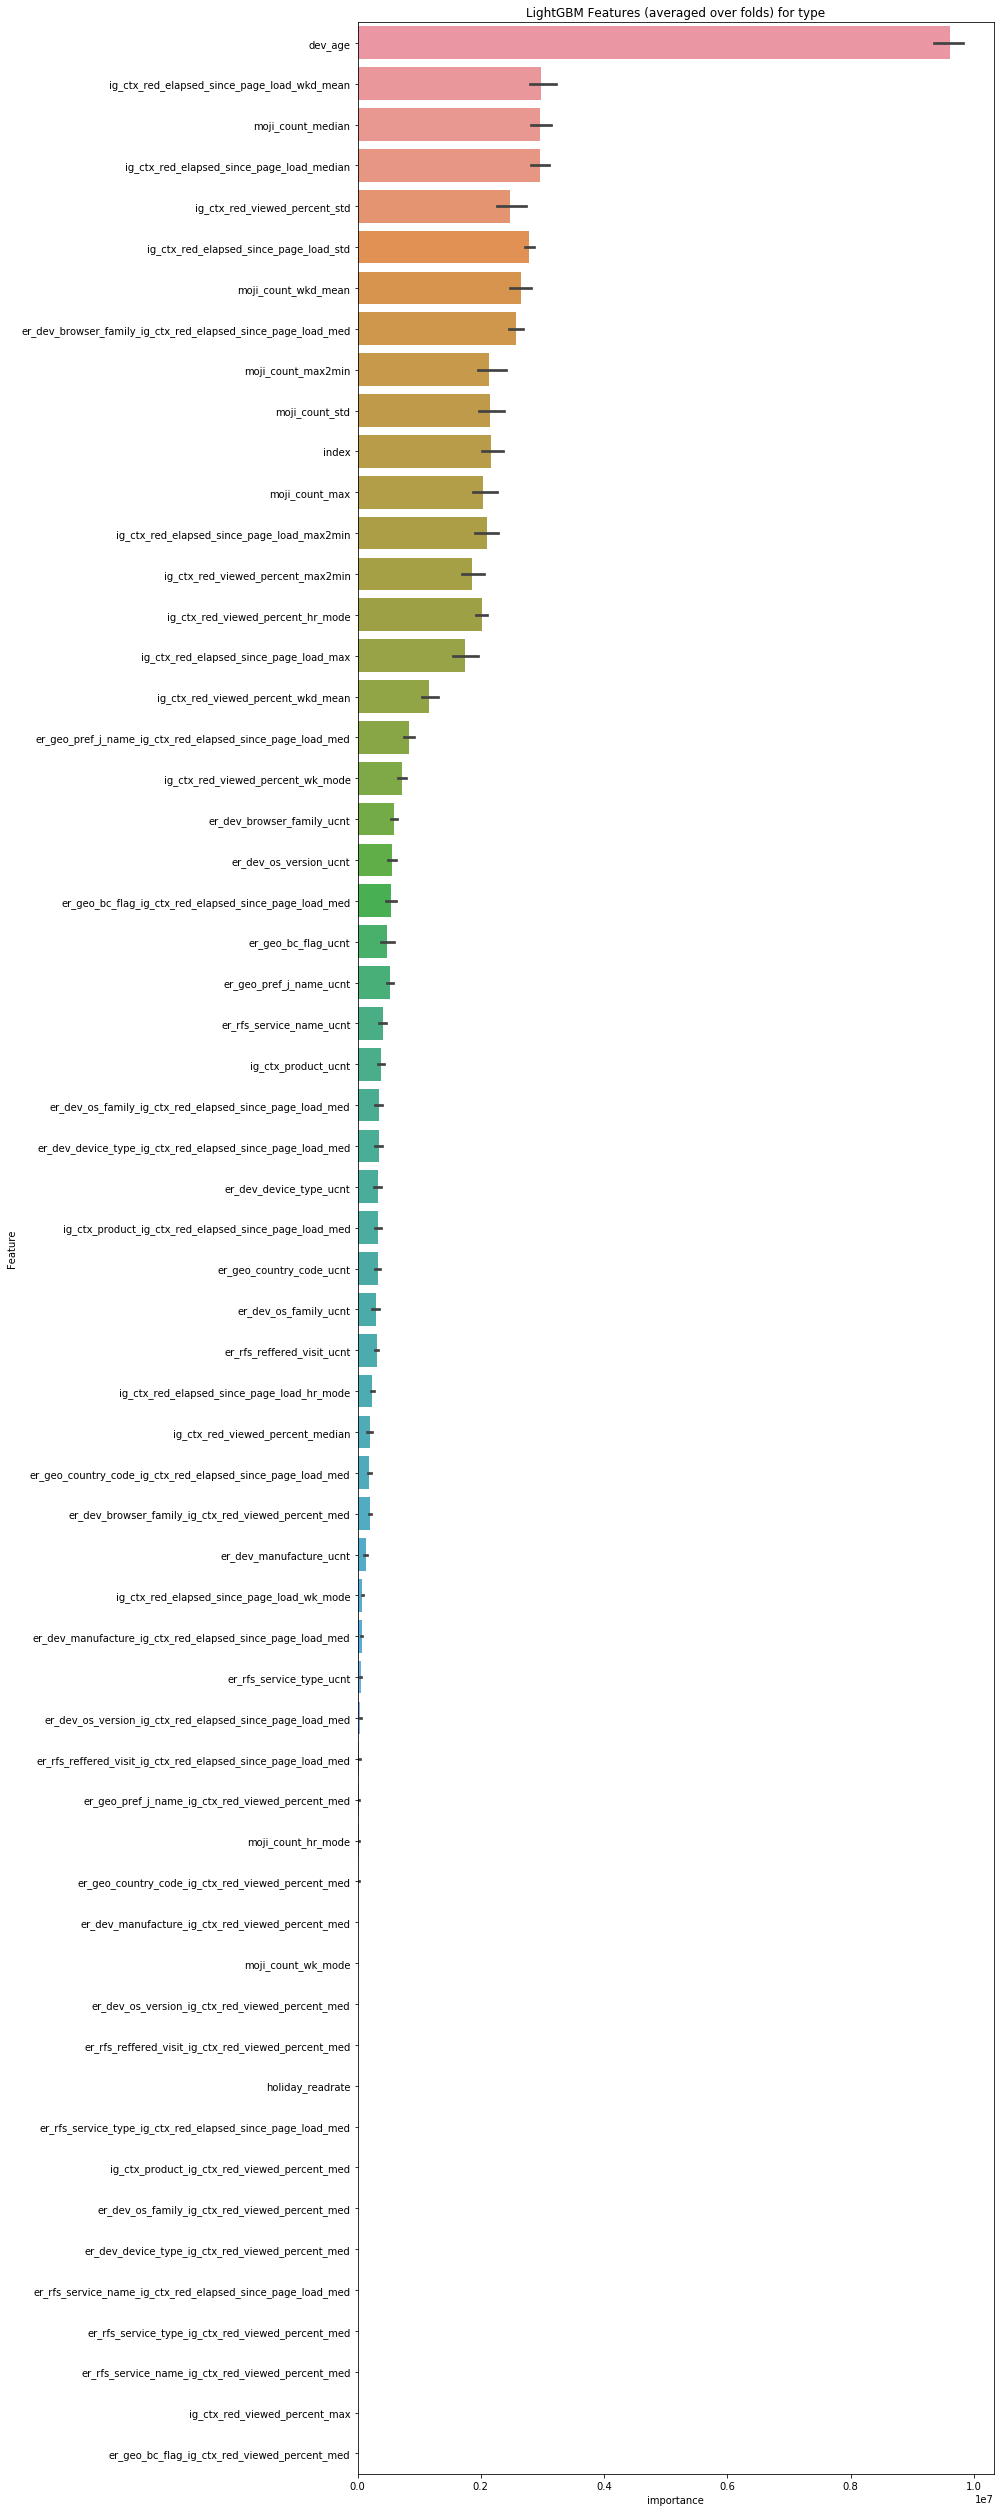

In [944]:
%%time
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:300].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]
plt.figure(figsize=(14,35))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds) for type')
plt.tight_layout()

In [907]:
%%time
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=6666)
oof = np.zeros(len(train))
#train_pred = np.zeros(len(train))
predictions = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

bag_num = 10
num_round = 1000
#split_groups = train['_weekday']
for i in range(bag_num):
    param_lgb = {'num_leaves': 256,
              'min_child_samples': 79,
              'objective': 'regression',
              'max_depth': 16,
              'learning_rate': 0.01,
              "boosting_type": "gbdt",
              "subsample_freq": 3,
              "subsample": 0.9,
              "bagging_seed": 666*(i+1),
              "metric": 'mae',
              "verbosity": -1,
              'reg_alpha': 0.3,
              'reg_lambda': 0.3,
              'colsample_bytree': 0.9,
              #'categorical_feature': cat_list
             }
    param = param_lgb 
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, target['age_range'].values)):
        #strLog = f'Fold {fold_ + 1} started at {time.ctime()}'
        #print(strLog)

        X_tr, X_val = train.iloc[trn_idx][features], train.iloc[val_idx][features]
        y_tr, y_val = train_y[trn_idx], train_y[val_idx]


        trn_data = lgb.Dataset(X_tr, label=y_tr)
        val_data = lgb.Dataset(X_val, label=y_val)

        model = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=200,
                  early_stopping_rounds = 100)
        oof[val_idx] +=  model.predict(X_val, num_iteration=model.best_iteration)/bag_num
        #predictions
        predictions += model.predict(test[features]) / (folds.n_splits*bag_num)
        
        #oof[val_idx] += (np.exp(model.predict(X_val, num_iteration=model.best_iteration)) -1)/bag_num
        #predictions
        #predictions += (np.exp(model.predict(test[features]) ) -1)/ (folds.n_splits*bag_num)

Training until validation scores don't improve for 100 rounds
[200]	training's l1: 9.18082	valid_1's l1: 10.005
[400]	training's l1: 8.27802	valid_1's l1: 9.82576
[600]	training's l1: 7.71742	valid_1's l1: 9.7825
Early stopping, best iteration is:
[688]	training's l1: 7.49135	valid_1's l1: 9.77685
Training until validation scores don't improve for 100 rounds
[200]	training's l1: 9.16224	valid_1's l1: 10.0965
[400]	training's l1: 8.27822	valid_1's l1: 9.93326
[600]	training's l1: 7.73203	valid_1's l1: 9.91634
Early stopping, best iteration is:
[666]	training's l1: 7.57047	valid_1's l1: 9.91227
Training until validation scores don't improve for 100 rounds
[200]	training's l1: 9.10236	valid_1's l1: 10.2216
[400]	training's l1: 8.20242	valid_1's l1: 10.1101
Early stopping, best iteration is:
[429]	training's l1: 8.10228	valid_1's l1: 10.1062
Training until validation scores don't improve for 100 rounds
[200]	training's l1: 9.17364	valid_1's l1: 10.0535
[400]	training's l1: 8.28789	valid_1'

Early stopping, best iteration is:
[591]	training's l1: 7.72057	valid_1's l1: 9.93353
Training until validation scores don't improve for 100 rounds
[200]	training's l1: 9.10906	valid_1's l1: 10.2195
[400]	training's l1: 8.22972	valid_1's l1: 10.1046
Early stopping, best iteration is:
[423]	training's l1: 8.14945	valid_1's l1: 10.1003
Training until validation scores don't improve for 100 rounds
[200]	training's l1: 9.17836	valid_1's l1: 10.0511
[400]	training's l1: 8.29694	valid_1's l1: 9.84437
[600]	training's l1: 7.74211	valid_1's l1: 9.80861
[800]	training's l1: 7.26366	valid_1's l1: 9.79886
[1000]	training's l1: 6.87134	valid_1's l1: 9.79425
Did not meet early stopping. Best iteration is:
[1000]	training's l1: 6.87134	valid_1's l1: 9.79425
Training until validation scores don't improve for 100 rounds
[200]	training's l1: 9.18014	valid_1's l1: 9.94886
[400]	training's l1: 8.28738	valid_1's l1: 9.77788
[600]	training's l1: 7.72181	valid_1's l1: 9.74643
[800]	training's l1: 7.26612	va

In [908]:
np.sqrt(mean_squared_error(train_y, oof))
# rmse :  13.314234519393993
# mae : 13.325016250712645
# 5fold cv seed avg x5 ==> cv = 12.61578498267412 @42 sec lb 
# added time features 12.531388783839988
# change stratify split 10 12.525934095593309
# change stratify split 20 12.521599771941814
# add holiday 12.467225661835602
# add service kategory and device :12.21338138639038
# seed avg 10 times :12.209682760376223  12.203302975702949(rmse)
# 12.200556881427678

12.200556881427678

In [915]:
%%time
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=6666)
oof3 = np.zeros(len(train))
#train_pred = np.zeros(len(train))
predictions3 = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

bag_num = 5
num_round = 1000
#split_groups = train['_weekday']
for i in range(bag_num):
    param_lgb = {'num_leaves': 256,
              'min_child_samples': 79,
              'objective': 'regression',
              'max_depth': 16,
              'learning_rate': 0.01,
              "boosting_type": "gbdt",
              "subsample_freq": 3,
              "subsample": 0.8,
              "bagging_seed": 666*(i+1),
              "metric": 'rmse',
              "verbosity": -1,
              'reg_alpha': 0.3,
              'reg_lambda': 0.3,
              'colsample_bytree': 0.9,
              #'categorical_feature': cat_list
             }
    param = param_lgb 
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, target['age_range'].values)):
        #strLog = f'Fold {fold_ + 1} started at {time.ctime()}'
        #print(strLog)

        X_tr, X_val = train.iloc[trn_idx][features], train.iloc[val_idx][features]
        y_tr, y_val = train_y[trn_idx], train_y[val_idx]


        trn_data = lgb.Dataset(X_tr, label=y_tr)
        val_data = lgb.Dataset(X_val, label=y_val)

        model = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=200,
                  early_stopping_rounds = 100)
        oof3[val_idx] +=  model.predict(X_val, num_iteration=model.best_iteration)/bag_num
        #predictions
        predictions3 += model.predict(test[features]) / (folds.n_splits*bag_num)
        
        #oof[val_idx] += (np.exp(model.predict(X_val, num_iteration=model.best_iteration)) -1)/bag_num
        #predictions
        #predictions += (np.exp(model.predict(test[features]) ) -1)/ (folds.n_splits*bag_num)

Training until validation scores don't improve for 100 rounds
[200]	training's rmse: 11.3392	valid_1's rmse: 12.3176
[400]	training's rmse: 10.4159	valid_1's rmse: 12.186
[600]	training's rmse: 9.74997	valid_1's rmse: 12.1868
Early stopping, best iteration is:
[523]	training's rmse: 9.98699	valid_1's rmse: 12.1787
Training until validation scores don't improve for 100 rounds
[200]	training's rmse: 11.3196	valid_1's rmse: 12.3518
[400]	training's rmse: 10.3974	valid_1's rmse: 12.2526
[600]	training's rmse: 9.73369	valid_1's rmse: 12.2484
Early stopping, best iteration is:
[513]	training's rmse: 10.0009	valid_1's rmse: 12.2456
Training until validation scores don't improve for 100 rounds
[200]	training's rmse: 11.28	valid_1's rmse: 12.4538
[400]	training's rmse: 10.3591	valid_1's rmse: 12.3947
Early stopping, best iteration is:
[343]	training's rmse: 10.583	valid_1's rmse: 12.3909
Training until validation scores don't improve for 100 rounds
[200]	training's rmse: 11.3492	valid_1's rmse:

In [916]:
np.sqrt(mean_squared_error(train_y, oof3))

12.189226821650978

## XGB Model

In [920]:
%%time
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=6666)
oof4 = np.zeros(len(train))
#train_pred = np.zeros(len(train))
predictions4 = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

bag_num = 1
num_round = 1000
#split_groups = train['_weekday']
for i in range(bag_num):
    print('bagnum:'+str(i))
    param_xgb = {'max_depth': 16
         , 'eta': 0.01
         , 'silent': 1
         , 'objective': 'reg:linear'
         , 'subsample': 0.8
         , 'colsample_bytree' : 0.8
         , 'eval_metric':'rmse'
         , 'nthread' : 4}
    param = param_xgb 
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, target['age_range'].values)):
        #strLog = f'Fold {fold_ + 1} started at {time.ctime()}'
        #print(strLog)

        X_tr, X_val = train.iloc[trn_idx][features], train.iloc[val_idx][features]
        y_tr, y_val = train_y[trn_idx], train_y[val_idx]
        
        trn_data = xgb.DMatrix(X_tr, label=y_tr)
        val_data = xgb.DMatrix(X_val, label=y_val)
        evalist = [(trn_data, 'train'), (val_data, 'test')]

        model = xgb.train(param, trn_data, num_round, evalist, verbose_eval=200, early_stopping_rounds = 100)
        oof4[val_idx] +=  model.predict(xgb.DMatrix(X_val), ntree_limit=model.best_ntree_limit)/bag_num
        #predictions
        predictions4 += model.predict(xgb.DMatrix(test[features]), ntree_limit=model.best_ntree_limit) / (folds.n_splits*bag_num)
        
        #oof[val_idx] += (np.exp(model.predict(X_val, num_iteration=model.best_iteration)) -1)/bag_num
        #predictions
        #predictions += (np.exp(model.predict(test[features]) ) -1)/ (folds.n_splits*bag_num)

bagnum:0
[0]	train-rmse:46.7725	test-rmse:46.8177
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 100 rounds.
[200]	train-rmse:9.52006	test-rmse:14.43
[400]	train-rmse:3.48907	test-rmse:12.5529
[600]	train-rmse:1.9309	test-rmse:12.4633
[800]	train-rmse:1.18083	test-rmse:12.4563
Stopping. Best iteration:
[808]	train-rmse:1.15901	test-rmse:12.456

[0]	train-rmse:46.7808	test-rmse:46.7919
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 100 rounds.
[200]	train-rmse:9.52189	test-rmse:14.4751
[400]	train-rmse:3.50755	test-rmse:12.5733
[600]	train-rmse:2.02101	test-rmse:12.4768
[800]	train-rmse:1.24782	test-rmse:12.4688
Stopping. Best iteration:
[786]	train-rmse:1.30077	test-rmse:12.4681

[0]	train-rmse:46.7759	test-rmse:46.808
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train unti

In [921]:
np.sqrt(mean_squared_error(train_y, oof4))


12.436236230435153

## RGF model

In [909]:
train2 = train.fillna(train.median()).copy()
test2 = test.fillna(train.median()).copy()

In [910]:
train2['holiday_readrate']=train2['holiday_readrate'].fillna(0)
test2['holiday_readrate']=test2['holiday_readrate'].fillna(0)

In [912]:
%%time
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=6666)
oof2 = np.zeros(len(train2))
#train2_pred = np.zeros(len(train2))
predictions2 = np.zeros(len(test2))
feature_importance_df2 = pd.DataFrame()


for fold_, (trn_idx, val_idx) in enumerate(folds.split(train2, target['age_range'].values)):
    #strLog = f'Fold {fold_ + 1} started at {time.ctime()}'
    #print(strLog)

    X_tr, X_val = train2.iloc[trn_idx][features], train2.iloc[val_idx][features]
    y_tr, y_val = train_y[trn_idx], train_y[val_idx]


    rgfr = rgf.RGFRegressor(verbose=True)
    model = rgfr.fit(X_tr, y_tr)
    oof2[val_idx] +=  model.predict(X_val)
    #predictions
    predictions2 += model.predict(test2[features]) / (folds.n_splits)

"train": 
   algorithm=RGF
   train_x_fn=/tmp/rgf/3d1ffcea-efb5-4a21-9db5-277115cf9f7822.train.data.x
   train_y_fn=/tmp/rgf/3d1ffcea-efb5-4a21-9db5-277115cf9f7822.train.data.y
   Log:ON
   model_fn_prefix=/tmp/rgf/3d1ffcea-efb5-4a21-9db5-277115cf9f7822.model
--------------------
Thu Dec 12 18:24:59 2019: Reading training data ... 
Thu Dec 12 18:24:59 2019: Start ... #train=11260
--------------------
Forest-level: 
   loss=LS
   max_leaf_forest=500
   max_tree=250
   opt_interval=100
   test_interval=100
   num_tree_search=1
   Verbose:ON
   memory_policy=Generous
-------------
Training data: 60x11260, nonzero_ratio=0.969; managed as dense data.
-------------
Optimization: 
   loss=LS
   num_iteration_opt=10
   reg_L2=0.1
   opt_stepsize=0.5
   NormalizeTarget:ON
Tree-level: min_pop=10
Node split: reg_L2=0.1
--------------------
Thu Dec 12 18:25:00 2019: Calling optimizer with 33 trees and 101 leaves
Thu Dec 12 18:25:00 2019: Writing model: seq#=1
Thu Dec 12 18:25:01 2019: Calling opti

"predict": 
   model_fn=/tmp/rgf/69a77f7a-f95f-47a5-8993-3d1d3e89a1ba24.model-05
   test_x_fn=/tmp/rgf/69a77f7a-f95f-47a5-8993-3d1d3e89a1ba24.test.data.x
   prediction_fn=/tmp/rgf/69a77f7a-f95f-47a5-8993-3d1d3e89a1ba24.predictions.txt
   Log:ON
--------------------
Thu Dec 12 18:25:15 2019: Reading test data ... 
Thu Dec 12 18:25:15 2019: Predicting ... 
elapsed: 0.036623
/tmp/rgf/69a77f7a-f95f-47a5-8993-3d1d3e89a1ba24.predictions.txt: /tmp/rgf/69a77f7a-f95f-47a5-8993-3d1d3e89a1ba24.model-05,#leaf=500,#tree=70
Thu Dec 12 18:25:15 2019: Done ... 

"train": 
   algorithm=RGF
   train_x_fn=/tmp/rgf/254d62c9-8180-48f7-b1d3-d9c61df2310c25.train.data.x
   train_y_fn=/tmp/rgf/254d62c9-8180-48f7-b1d3-d9c61df2310c25.train.data.y
   Log:ON
   model_fn_prefix=/tmp/rgf/254d62c9-8180-48f7-b1d3-d9c61df2310c25.model
--------------------
Thu Dec 12 18:25:15 2019: Reading training data ... 
Thu Dec 12 18:25:16 2019: Start ... #train=11273
--------------------
Forest-level: 
   loss=LS
   max_leaf_fores

In [913]:
np.sqrt(mean_squared_error(train_y, oof2))
# rgf 

12.329143738293649

# Submission

In [922]:
train_stack = np.vstack([oof,oof2, oof3,oof4]).transpose()
test_stack = np.vstack([predictions,predictions2, predictions3,predictions4]).transpose()

folds_stack = RepeatedKFold(n_splits=5, n_repeats=1, random_state=6666)
oof_stack = np.zeros(train_stack.shape[0])
predictions_fin = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack)):
    print("fold {}".format(fold_+1))
    X_tr, X_val = train_stack[trn_idx], train_stack[val_idx]
    y_tr, y_val = train_y[trn_idx], train_y[val_idx]
    
    clf_fin = BayesianRidge()
    clf_fin.fit(X_tr, y_tr)
    
    oof_stack[val_idx] = clf_fin.predict(X_val)
    predictions_fin += clf_fin.predict(test_stack) / 5
    
np.sqrt(mean_squared_error(train_y, oof_stack))
# 12.198285507984322
#12.184396158866482

fold 1
fold 2
fold 3
fold 4
fold 5


12.184659255263048

In [628]:
np.sqrt(mean_squared_error(train_y, (oof3)))
# rgf + lgb 12.501854735211062
# lgb mae + rmse :12.204637754527873

12.202892143420613

In [349]:
sub_df.head()

,user_id,age
0,1406160,45
1,1544000,45
2,2214470,45
3,2364720,45
4,5127600,45


In [420]:
predictions

array([49.26893402, 48.22936296, 41.77657773, ..., 45.75210964,
       53.59621789, 45.39428571])

In [923]:
sub_df['age'] = predictions_fin

In [924]:
%%time
dt = datetime.now().strftime("%Y%m%d_%H:%M")
sub_df.to_csv(f'{SUBPATH}/sub_stack'+dt+'_v08.csv', index=False)

CPU times: user 112 ms, sys: 8 ms, total: 120 ms
Wall time: 29.5 ms
